In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
dataset_path = 'Twitter_Data.csv'
df = pd.read_csv(
    dataset_path
)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [26]:
# just take half of the data
df = df.sample(frac=0.1, random_state=42)

In [27]:
null_rows = df.isnull().any(axis=1)
df[null_rows]

,clean_text,category


In [28]:
df = df.dropna()

In [29]:
def text_normalize(text):
  # Lowercasing
  text = text.lower()

  # Retweet old acronym "RT" removal
  text = re.sub(r'rt[\s]+', '', text)

  # Hyperlinks removal
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  # Punctuation removal
  text = re.sub(r'[^\w\s]', '', text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  words = text.split()
  words = [word for word in words if word not in stop_words]
  text = ' '.join(words)

  # Stemming
  stemmer = SnowballStemmer('english')
  words = text.split()
  words = [stemmer.stem(word) for word in words]
  text = ' '.join(words)

  return text

In [30]:
df['clean_text'] = df['clean_text'].apply(lambda x: text_normalize(x))

In [31]:
vectorizer = TfidfVectorizer(max_features=50000, min_df=5, max_df=0.8)
X = vectorizer.fit_transform(df['clean_text']).toarray() 

In [32]:
intercept = np.ones((X.shape[0], 1))  # Create a column of ones
X_b = np.concatenate((intercept, X), axis=1)  # Concatenate with X

In [33]:
n_classes = df['category'].nunique()
n_samples = df['category'].size
y = df['category'].to_numpy() + 1  # Shift labels to start from 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

In [34]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [35]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 11408
Number of val samples: 3260
Number of test samples: 1630


In [40]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1)[:, None]

def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)
    return y_hat

def compute_loss(y_hat, y):
    n = y.size
    return (-1 / n) * np.sum(y * np.log(y_hat))

def compute_gradient(X, y, y_hat):
    n = y.size
    return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return acc


In [41]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(
    size=(n_features, n_classes)
)

In [42]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    # Batch processing
    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]
        
        # Prediction
        y_hat = predict(X_i, theta)
        
        # Loss and Gradient Computation
        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)
        
        # Track batch losses and accuracies
        train_batch_losses.append(train_loss)
        train_acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(train_acc)

    # Validation
    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_acc = compute_accuracy(X_val, y_val, theta)

    # Store validation metrics
    val_batch_losses.append(val_loss)
    val_batch_accs.append(val_acc)

    # Compute mean losses and accuracies for the epoch
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    # Append epoch metrics
    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    # Print epoch summary
    print(f'\nEPOCH {epoch + 1}: Training loss: {train_batch_loss:.3f} | Validation loss: {val_batch_loss:.3f}')



EPOCH 1: Training loss: 0.376 | Validation loss: 0.374

EPOCH 2: Training loss: 0.376 | Validation loss: 0.374

EPOCH 3: Training loss: 0.376 | Validation loss: 0.374

EPOCH 4: Training loss: 0.375 | Validation loss: 0.373

EPOCH 5: Training loss: 0.375 | Validation loss: 0.373

EPOCH 6: Training loss: 0.375 | Validation loss: 0.373

EPOCH 7: Training loss: 0.374 | Validation loss: 0.373

EPOCH 8: Training loss: 0.374 | Validation loss: 0.372

EPOCH 9: Training loss: 0.374 | Validation loss: 0.372

EPOCH 10: Training loss: 0.374 | Validation loss: 0.372

EPOCH 11: Training loss: 0.373 | Validation loss: 0.371

EPOCH 12: Training loss: 0.373 | Validation loss: 0.371

EPOCH 13: Training loss: 0.373 | Validation loss: 0.371

EPOCH 14: Training loss: 0.373 | Validation loss: 0.371

EPOCH 15: Training loss: 0.372 | Validation loss: 0.371

EPOCH 16: Training loss: 0.372 | Validation loss: 0.370

EPOCH 17: Training loss: 0.372 | Validation loss: 0.370

EPOCH 18: Training loss: 0.372 | Valida

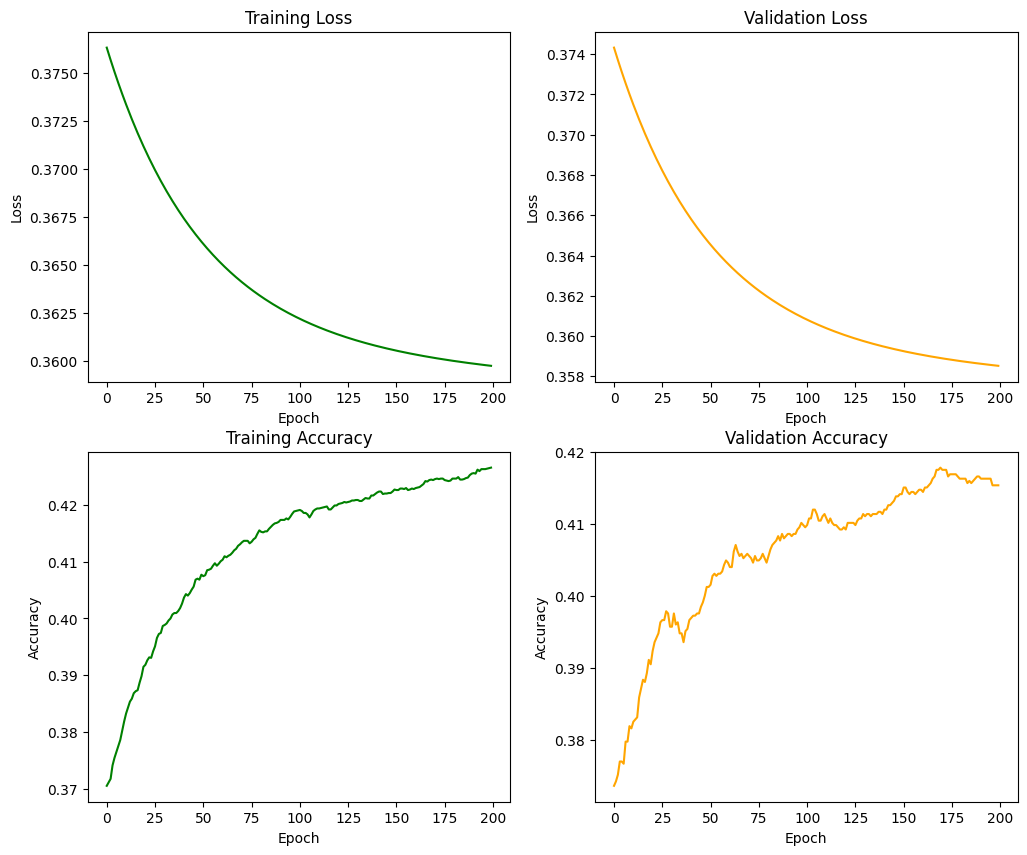

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [44]:
# Val set
val_set_acc = compute_accuracy(X_val, y_val, theta)
print('Evaluation on validation set:')
print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.4153374233128834


In [45]:
# Test set
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on test set:')
print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.4214723926380368
